In [2]:
!pip install open3d


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Valid depth pixels: 942,559
Depth min/max: 0.366 / 2.993 m


/tmp/ipython-input-3040455563.py:69: RuntimeWarning: invalid value encountered in cast
  d = (d / max_display_depth * 255).astype(np.uint8)


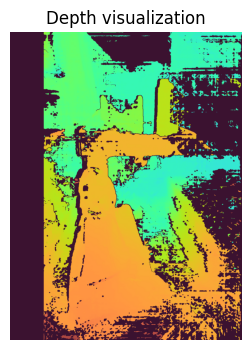

depth map saved npy
Generated points: 942,559
After cleaning: 910,580
完了：CloudCompareで確認してください


In [3]:

!pip install -q open3d

from google.colab import drive
drive.mount('/content/drive')

import open3d as o3d
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2


BASE_DIR = "/content/drive/MyDrive/Amazon project/processed_images"

COLOR_FILE = os.path.join(BASE_DIR, "left_final.png")
DISPARITY_FILE = os.path.join(BASE_DIR, "disparity_final.npy")


K = np.array([
    [1.15994113e+03, 0.00000000e+00, 5.46000399e+02],
 [0.00000000e+00, 1.15929016e+03, 7.32384585e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]
, dtype=np.float64)


D = 0.32 * np.array( [ 7.68506874e-03, -1.33669015e-01, -5.20174312e-05,  4.92592454e-04,
  0.00000000e+00], dtype=np.float64)

FX, FY = K[0,0], K[1,1]
CX, CY = K[0,2], K[1,2]

BASELINE = 0.05   # 5 cm
MAX_DEPTH = 3.0  # meter


def disparity_to_depth(disparity):
    depth = np.zeros_like(disparity, dtype=np.float32)

    MIN_DISPARITY = 3.0
    valid = disparity > MIN_DISPARITY
    depth[valid] = (FX * BASELINE) / disparity[valid]

    depth[(depth <= 0) | (depth > MAX_DEPTH)] = 0
    return depth


def apply_depth_mask(depth, disparity):
    depth_masked = depth.copy()


    depth_masked[disparity < 3.0] = 0


    gx = cv2.Sobel(depth, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(depth, cv2.CV_32F, 0, 1, ksize=3)
    grad = np.sqrt(gx**2 + gy**2)

    depth_masked[grad > 0.5] = 0
    depth_masked[~np.isfinite(depth_masked)] = 0

    return depth_masked


def visualize_depth(depth, max_display_depth=5.0):
    d = depth.copy()
    d[d <= 0] = np.nan
    d[d > max_display_depth] = max_display_depth
    d = (d / max_display_depth * 255).astype(np.uint8)
    d_color = cv2.applyColorMap(d, cv2.COLORMAP_TURBO)

    plt.figure(figsize=(6,4))
    plt.imshow(d_color)
    plt.title("Depth visualization")
    plt.axis("off")
    plt.show()


def run():

    if not os.path.exists(COLOR_FILE) or not os.path.exists(DISPARITY_FILE):
        print("ファイルが見つかりません")
        return

    # ---------- Load ----------
    color_raw = cv2.imread(COLOR_FILE)
    color_raw = cv2.cvtColor(color_raw, cv2.COLOR_BGR2RGB)

    disparity = np.load(DISPARITY_FILE).astype(np.float32)
    if disparity.ndim == 3:
        disparity = disparity[:,:,0]

    h, w = color_raw.shape[:2]


    newK, _ = cv2.getOptimalNewCameraMatrix(
        K, D, (w, h), alpha=0.0
    )

    color_undist = cv2.undistort(color_raw, K, D, None, newK)

    color = o3d.geometry.Image(color_undist)

    depth_raw = disparity_to_depth(disparity)
    depth = apply_depth_mask(depth_raw, disparity)

    valid = depth > 0
    print(f"Valid depth pixels: {np.sum(valid):,}")
    print(f"Depth min/max: {depth[valid].min():.3f} / {depth[valid].max():.3f} m")

    visualize_depth(depth)


    depth_save_dir = BASE_DIR

    #  NumPy
    np.save(
        os.path.join(depth_save_dir, "depth.npy"),
        depth
    )

    print("depth map saved npy")





    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color,
        o3d.geometry.Image(depth),
        depth_scale=1.0,
        depth_trunc=MAX_DEPTH,
        convert_rgb_to_intensity=False
    )

    intrinsic = o3d.camera.PinholeCameraIntrinsic(
        w, h, newK[0,0], newK[1,1], newK[0,2], newK[1,2]
    )

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)

    # Open3D
    pcd.transform([
        [1, 0, 0, 0],
        [0,-1, 0, 0],
        [0, 0,-1, 0],
        [0, 0, 0, 1]
    ])

    print(f"Generated points: {len(pcd.points):,}")


    pcd, _ = pcd.remove_statistical_outlier(
        nb_neighbors=20,
        std_ratio=2.0
    )

    print(f"After cleaning: {len(pcd.points):,}")


    o3d.io.write_point_cloud(
        os.path.join(BASE_DIR, "reconstruction_masked.ply"), pcd
    )

    print("完了：CloudCompareで確認してください")


run()
